# Deep Learning for Rating Prediction on the Yelp Dataset

In [1]:
# this is set to make the first "Run All" faster
first_run = True

In [2]:
# downloads the pretrained models (if not downloaded already)
!ls saved 2>/dev/null || git clone https://github.com/de-lachende-cavalier/amd-project saved

models


In [3]:
!find saved -maxdepth 1 -type f -delete || echo "Are you sure you cloned the repo?"

## Imports

First, let's make sure that we have all the necessary libraries.

In [4]:
%pip install --upgrade tensorflow matplotlib pandas folium kaggle scikit-learn seaborn keras


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


The imports below are all ML/DL related.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

The imports below are mostly utility imports.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import json
import os
import folium

## Data retrieval from Kaggle

Simply copy-paste your username and key below and run all the cells below to get the data.

In [7]:
os.environ['KAGGLE_USERNAME'] = "x"
os.environ['KAGGLE_KEY'] = "x"

In [8]:
!kaggle datasets download -d yelp-dataset/yelp-dataset || echo "You probably forgot to insert you credentials in the code cell above!"

401 - Unauthorized
You probably forgot to insert you credentials in the code cell above!


The OR (`||`) in the cells below is so that one can run all the cells multiple times, without having to worry about skipping these two (which would impede the process, seeing as they would return an error).

In [9]:
!mkdir yelp-data || echo "Directory is ready."

mkdir: yelp-data: File exists
Directory is ready.


In [10]:
!echo "N" | unzip -d yelp-data yelp-dataset.zip || echo "Data is ready." # the initial echo is to tell unzip to not replace any file if the files exist already

Archive:  yelp-dataset.zip
replace yelp-data/Dataset_User_Agreement.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Data examination

### Let's define some useful functions...

In [11]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file_path, max_nl=None):
    """
    Read a JSON file and convert its contents into a pandas DataFrame.

    Args:
        file_path (str): The path to the JSON file.
        max_nl (int, optional): The maximum number of lines to read. Defaults to None (read the whole file).

    Returns:
        pandas.DataFrame: The DataFrame containing the parsed JSON data.
    """
    with open(file_path, 'r') as f:
      data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

    return pd.DataFrame(data)

### ...define some useful variables

In [12]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)

### ... and turn our data into a pandas DataFrame for further examination.

In [13]:
review_file = "yelp_academic_dataset_review.json"

In [14]:
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

Great! Let's see what we're dealing with.

In [15]:
review_df.head() # to get an idea as to what we're dealing with

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


It seems that the two key columns are 'stars' and 'text', the former as a label and the latter as our features. The 'useful', 'funny' and 'cool' columns also look interesting, but it seems like they're more about the review per se than the place being reviewed and are made a posteriori (i.e. after the review has already been made and the rating has been assigned, check [here](https://aghenai.github.io/assets/publications/Amira_Ghenai_Final_Report.pdf)), so we can't really use them for much.

In [16]:
review_df.drop(columns=['useful', 'funny', 'cool'], inplace=True) # it's no use carrying useless data around...

Let's get some extra information.

In [17]:
review_df.info() # all entries are non-null! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   text         100000 non-null  object 
 5   date         100000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.6+ MB


No nulls anywhere, wonderful news! Let's quickly check out the statistics of the stars column.

In [18]:
review_df.describe()

,stars
count,100000.000000
mean,3.842910
std,1.354729
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


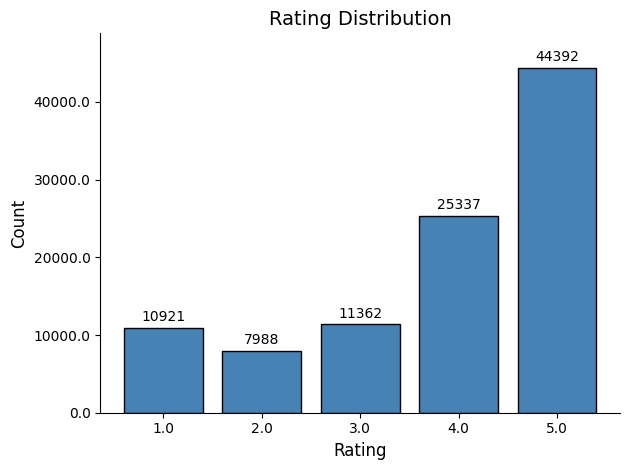

In [19]:
# sort the ratings in ascending order
sorted_ratings = review_df['stars'].value_counts().sort_index()

# Create a bar plot
fig, ax = plt.subplots()

ax.bar(sorted_ratings.index, sorted_ratings.values, color='steelblue', edgecolor='black')

# set plot title and labels
ax.set_title('Rating Distribution', fontsize=14)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# customize the tick labels and axis limits
ax.set_xticks(sorted_ratings.index)
ax.set_xticklabels(sorted_ratings.index, fontsize=10)

ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.set_yticklabels(ax.get_yticks(), fontsize=10)
ax.set_ylim(0, sorted_ratings.max() * 1.1)

# Remove spines and add grid lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add data labels above each bar
for x, y in zip(sorted_ratings.index, sorted_ratings.values):
    ax.text(x, y + 0.02 * sorted_ratings.max(), str(y), ha='center', fontsize=10)

fig.tight_layout()

plt.show()

Interesting distribution. It seems that most of the reviews are positive, and a reasonable amount of them as positive as they can be!

### Let's inspect the data some more, for the fun of it.

I don't like the identifiers we're currently working with, and would rather like to see the names of the various businesses and their locations.

In [20]:
business_file = "yelp_academic_dataset_business.json"

business_df = read_to_dataframe(data_dir + business_file) # no need to set a limit (the file is 113MB large)
business_df.drop(columns=["stars"], inplace=True) # this is the rating of the businesses (we don't care about that)

In [21]:
rich_df = pd.merge(review_df, business_df, on="business_id")

Ok, let's see what this "rich" data gives us...

In [22]:
rich_df.head()

,review_id,user_id,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,VJxlBnJmCDIy8DFG0kjSow,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,This is the second time we tried turning point...,2017-05-13 17:06:55,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
2,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,The place is cute and the staff was very frien...,2017-08-08 00:58:18,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
4,M0wzFFb7pefOPcxeRVbLag,dCooFVCk8M1nVaQqcfTL3Q,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."


Perfect: we know get some extra information about the business. Everything is much more human readable now and ameanable to further exploration. I only intend to take a look at a geographical visualization, but the possibilites are endless. I encourage you to explore them, if you wish.

Graphically speaking, we can use the `folium` library.

In [23]:
fol_fig = folium.Figure(width=1000, height=600)

# Create a map object centered at a specific location (e.g., the geographical center of North America (we know the data is from USA and Canada))
map_obj = folium.Map(location=[39.7392, -104.9903], zoom_start=4, tiles='Stamen Toner').add_to(fol_fig)

sampled_df = rich_df.sample(n=1000) # to speed up execution (up to 1000 works fine, above that it starts to slow down significantly)

# add markers for each data point
for index, row in sampled_df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    folium.Marker([latitude, longitude]).add_to(map_obj)

map_obj

So it seems that our data is mostly made up of businesses on the east and west coasts of the USA, and then Canada. That's interesting (and not particularly surprising).

Now, onto more interesting things!

## Prepare the data 

### Let's define some useful functions...

In [24]:
def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    """
    Create train, validation, and test datasets from the given DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        feature_columns (list): List of column names representing the feature columns.
        label_column (str): The name of the column representing the label.
        train_size (float or int): The proportion or absolute number of samples for the training set.
        test_size (float or int): The proportion or absolute number of samples for the test set.
        random_state (int or None): Random state for reproducible results.
        
    Returns:
        tuple: A tuple containing X_train, X_val, X_test, y_train, y_val, y_test datasets.
    """
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    """
    Prepare the train, validation, and test datasets for model training and evaluation.
    
    Args:
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        test_dataset (tf.data.Dataset): The test dataset.
        m (int): The buffer size for shuffling the training dataset.
        preprocess_fn (callable): The preprocessing function to apply to the datasets.
        batch_size (int): The batch size for training, validation, and testing.
        
    Returns:
        tuple: A tuple containing the prepared train, validation, and test datasets.
    """
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepared = train_dataset.map(lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepared = train_dataset_prepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepared, val_dataset_prepared, test_dataset_prepared

### ... and some useful variables, as usual.

In [25]:
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

### Ok, now on to data preparation.

In [26]:
# only get data from the review DataFrame (the one in the rich_df is more for exploratory purposes)
X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42) # the random state is set for reproducibility

print("[+] Training set shape:", X_train.shape, y_train.shape)
print("[+] Validation set shape:", X_val.shape, y_val.shape)
print("[+] Testing set shape:", X_test.shape, y_test.shape)

[+] Training set shape: (70000,) (70000,)
[+] Validation set shape: (15000,) (15000,)
[+] Testing set shape: (15000,) (15000,)


We need to make sure that the data is in a format that `TensorFlow`  now can work with.

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Also, we need to define the function we're going to use to preprocess the data and prepare it for the model, which, thanks to `keras`, is incredibly easy: the `TextVectorization` layer is capable of processing textual data E2E, i.e. from standardization, to tokenization and to vectorization!

In [28]:
# it's almost magical...
text_vectorization_1gram = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

Before moving on, we need to build the vocabulary, i.e. we need to fundamentally build the vector space that we'll operate in.

In [29]:
# this might take a while (~20s)
text_vectorization_1gram.adapt(train_dataset.map(lambda review, label: review))

In [30]:
text_vectorization_1gram.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'are',
 'good',
 'at',
 'place',
 'great',
 'be',
 'as',
 'very',
 'there',
 'all',
 'our',
 'if',
 'here',
 'out',
 'me',
 'service',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'from',
 'their',
 'back',
 'would',
 'when',
 'or',
 'an',
 'go',
 'up',
 'really',
 'about',
 'which',
 'will',
 'been',
 'also',
 'some',
 'what',
 'no',
 'only',
 'more',
 'she',
 'can',
 'your',
 'us',
 'nice',
 'best',
 'got',
 'by',
 'he',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'ive',
 'im',
 'friendly',
 'has',
 'delicious',
 'always',
 'after',
 'order',
 'do',
 'restaurant',
 'little',
 'than',
 'came',
 'chicken',
 'definitely',
 'try',
 'didnt',
 'first',
 'menu',
 'did',
 'went',
 'could',
 'never',
 'amazing',
 'much',
 '

Great, now we can finally turn the data in a format accepted by the model.

In [31]:
train_dataset_prep_1gram, val_dataset_prep_1gram, test_dataset_prep_1gram = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_1gram)

Let's see if everything worked.

In [32]:
for inputs, targets in train_dataset_prep_1gram:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)

    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)

    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

2023-07-01 18:29:37.620765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 43693 of 70000
2023-07-01 18:29:43.570056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


inputs.shape: (64, 30000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'float64'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(30000,), dtype=float32)
targets[0]: tf.Tensor(2.0, shape=(), dtype=float64)


Looks good!

## Let's try a Bag-of-Words approach 

### As above, the first cell will contain some useful functions.

In [33]:
def create_bow_model(input_dim):
    input = layers.Input(shape=(input_dim,))

    # the network below is pretty small, mostly because the previous one (which was quite a bit bigger) simply kept crashing the Colab kernel
    x = layers.Dense(256, activation='relu')(input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(1)(x)

    model = keras.Model(inputs=input, outputs=output)

    # I'm going to treat this as a regression problem (although it could be also be seen as a classification) 
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse'])

    return model

def plot_training_curves(history):
    """
    Plot the training and validation loss curves.

    Args:
        history: History object returned by the model training process.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

### Let us begin with the simplest possible model: a 1-gram model.

The first approach we're going to try is a simple Bag-of-Words approach, i.e. we'll treat the various tokens (in our case the single words) as elements of a set (i.e. the bag of words) and we'll ignore the order in which they're presented. There will be time for more complicated models later on. For now, we simply want a baseline.

In [34]:
# the model we created is 1-gram, i.e. each word represents a single element in the set
model_1gram = create_bow_model(vocabulary_size)

In [35]:
model_1gram.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 256)               7680256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_1gram", save_best_only=True)
]

history_1gram = model_1gram.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep_1gram,
    validation_data=val_dataset_prep_1gram,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-07-01 18:29:54.150277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44277 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 12.2767 - mse: 12.2767  

2023-07-01 18:29:59.975558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 1.6954 - mse: 1.6954INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 39s 21ms/step - loss: 1.6954 - mse: 1.6954 - val_loss: 0.6571 - val_mse: 0.6571
Epoch 2/10


2023-07-01 18:30:33.272028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44824 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 1.0449 - mse: 1.0449

2023-07-01 18:30:38.975441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.9542 - mse: 0.9542INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 38s 20ms/step - loss: 0.9542 - mse: 0.9542 - val_loss: 0.5891 - val_mse: 0.5891
Epoch 3/10


2023-07-01 18:31:11.334544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44764 of 70000


   9/1094 [..............................] - ETA: 17s - loss: 0.7636 - mse: 0.7636  

2023-07-01 18:31:17.180562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.7460 - mse: 0.7460INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 40s 22ms/step - loss: 0.7460 - mse: 0.7460 - val_loss: 0.5631 - val_mse: 0.5631
Epoch 4/10


2023-07-01 18:31:50.910919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 44076 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.6736 - mse: 0.6736

2023-07-01 18:31:56.893394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.6080 - mse: 0.6080INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 39s 21ms/step - loss: 0.6080 - mse: 0.6080 - val_loss: 0.5434 - val_mse: 0.5434
Epoch 5/10


2023-07-01 18:32:29.825652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45240 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.4628 - mse: 0.4628

2023-07-01 18:32:35.425416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 37s 19ms/step - loss: 0.5208 - mse: 0.5208 - val_loss: 0.5460 - val_mse: 0.5460
Epoch 6/10


2023-07-01 18:33:06.744890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 46190 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.4602 - mse: 0.4602

2023-07-01 18:33:12.082820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.4549 - mse: 0.4549INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 37s 20ms/step - loss: 0.4547 - mse: 0.4547 - val_loss: 0.5302 - val_mse: 0.5302
Epoch 7/10


2023-07-01 18:33:43.472938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 46510 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.3864 - mse: 0.3864

2023-07-01 18:33:48.678603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.4022 - mse: 0.4022INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 36s 19ms/step - loss: 0.4021 - mse: 0.4021 - val_loss: 0.5279 - val_mse: 0.5279
Epoch 8/10


2023-07-01 18:34:19.677456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 46403 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.3648 - mse: 0.3648

2023-07-01 18:34:24.951877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.3664 - mse: 0.3664INFO:tensorflow:Assets written to: model_bow_1gram/assets


INFO:tensorflow:Assets written to: model_bow_1gram/assets


1094/1094 [==============================] - 37s 20ms/step - loss: 0.3663 - mse: 0.3663 - val_loss: 0.5208 - val_mse: 0.5208
Epoch 9/10


2023-07-01 18:34:56.296261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45445 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.3332 - mse: 0.3332

2023-07-01 18:35:01.920532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 38s 21ms/step - loss: 0.3375 - mse: 0.3375 - val_loss: 0.5222 - val_mse: 0.5222
Epoch 10/10


2023-07-01 18:35:34.781530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 45486 of 70000


  12/1094 [..............................] - ETA: 16s - loss: 0.3107 - mse: 0.3107

2023-07-01 18:35:40.277484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 22ms/step - loss: 0.3119 - mse: 0.3119 - val_loss: 0.5289 - val_mse: 0.5289


Not too bad, it seems (and it trains lightning fast). Let's look at the training and validation curves.

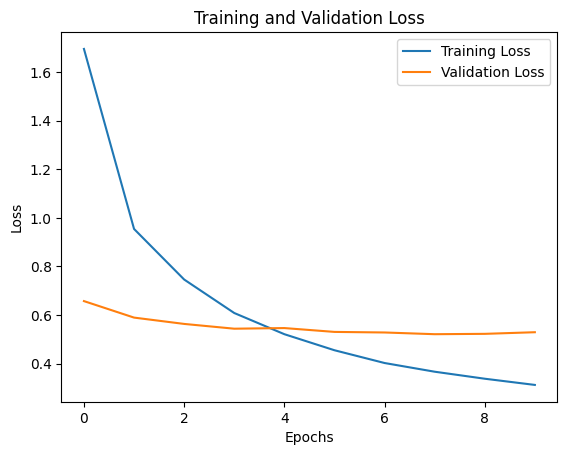

In [37]:
plot_training_curves(history_1gram)

It seems like some light overfitting happened in the latter epochs. The validation loss bounces around 0.6, so it seems to indicate that that's about as well as our model can perform. Overall, the result is not the worst (our rating will, seeing as we get a mean error of ~0.72 (sqrt(0.52))).

For now, though, let's experiment with a 2-gram model (i.e. our tokens are going to be made up of two words each, so we'll inject some local order information into it).

### Let's add some local order information: a bigram (2-gram) model.

In [38]:
text_vectorization_2gram = layers.TextVectorization(
    ngrams=2, # yes, it is that simple!
    max_tokens=vocabulary_size,
    output_mode='multi_hot',
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

Naturally, we need to rebuild the vocabulary (we're adding some new basis vectors after all).

In [39]:
text_vectorization_2gram.adapt(train_dataset.map(lambda review, label: review))

In [40]:
text_vectorization_2gram.get_vocabulary() # notice how we now have basis vectors made up of two words (e.g "the hotel")

['[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'are',
 'good',
 'at',
 'place',
 'great',
 'be',
 'as',
 'very',
 'there',
 'all',
 'our',
 'if',
 'here',
 'out',
 'me',
 'of the',
 'it was',
 'service',
 'and the',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'in the',
 'from',
 'their',
 'back',
 'would',
 'when',
 'or',
 'an',
 'go',
 'up',
 'really',
 'about',
 'which',
 'this place',
 'will',
 'been',
 'on the',
 'also',
 'some',
 'what',
 'i was',
 'and i',
 'no',
 'the food',
 'only',
 'more',
 'she',
 'can',
 'your',
 'us',
 'nice',
 'best',
 'got',
 'for a',
 'by',
 'he',
 'to the',
 'for the',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'ive',
 'im',
 'i had',
 'friendly',
 'has',
 'delicious',
 'always',
 'after',
 'order',
 'do',
 'restaurant',
 'is a

Just as naturally, we need to re-prepare the data!

In [41]:
train_dataset_prep_2gram, val_dataset_prep_2gram, test_dataset_prep_2gram = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_2gram)

We use the exact same architecture: we want to see whether using bigrams helps, after all, and changing architecture would only impede this ascertainment.

In [42]:
model_2gram = create_bow_model(vocabulary_size)

In [43]:
model_2gram.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_4 (Dense)             (None, 256)               7680256   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_2gram", save_best_only=True)
]

history_2gram = model_2gram.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep_2gram,
    validation_data=val_dataset_prep_2gram,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-07-01 18:36:37.617137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41284 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 11.2330 - mse: 11.2330  

2023-07-01 18:36:44.525423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 1.8528 - mse: 1.8528INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 1.8526 - mse: 1.8526 - val_loss: 0.8039 - val_mse: 0.8039
Epoch 2/10


2023-07-01 18:37:17.798391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42335 of 70000


  12/1094 [..............................] - ETA: 17s - loss: 1.1529 - mse: 1.1529

2023-07-01 18:37:24.507956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 1.0015 - mse: 1.0015INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 21ms/step - loss: 1.0015 - mse: 1.0015 - val_loss: 0.6570 - val_mse: 0.6570
Epoch 3/10


2023-07-01 18:37:57.211000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42216 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.7626 - mse: 0.7626

2023-07-01 18:38:03.911993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.7013 - mse: 0.7013INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 39s 20ms/step - loss: 0.7013 - mse: 0.7013 - val_loss: 0.5471 - val_mse: 0.5471
Epoch 4/10


2023-07-01 18:38:36.204577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42655 of 70000


   9/1094 [..............................] - ETA: 17s - loss: 0.5487 - mse: 0.5487  

2023-07-01 18:38:42.946624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.5542 - mse: 0.5542INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.5542 - mse: 0.5542 - val_loss: 0.5007 - val_mse: 0.5007
Epoch 5/10


2023-07-01 18:39:16.072864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41209 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.4499 - mse: 0.4499

2023-07-01 18:39:23.253766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.4617 - mse: 0.4617 - val_loss: 0.5016 - val_mse: 0.5016
Epoch 6/10


2023-07-01 18:39:54.997188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41932 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.4632 - mse: 0.4632

2023-07-01 18:40:02.031746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.3959 - mse: 0.3959INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.3959 - mse: 0.3959 - val_loss: 0.4983 - val_mse: 0.4983
Epoch 7/10


2023-07-01 18:40:34.723107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42659 of 70000


  11/1094 [..............................] - ETA: 17s - loss: 0.3398 - mse: 0.3398

2023-07-01 18:40:41.281709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.3465 - mse: 0.3465INFO:tensorflow:Assets written to: model_bow_2gram/assets


INFO:tensorflow:Assets written to: model_bow_2gram/assets


1094/1094 [==============================] - 38s 20ms/step - loss: 0.3465 - mse: 0.3465 - val_loss: 0.4722 - val_mse: 0.4722
Epoch 8/10


2023-07-01 18:41:13.145086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42821 of 70000


   8/1094 [..............................] - ETA: 18s - loss: 0.3094 - mse: 0.3094  

2023-07-01 18:41:19.587291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 21ms/step - loss: 0.3093 - mse: 0.3093 - val_loss: 0.4929 - val_mse: 0.4929
Epoch 9/10


2023-07-01 18:41:52.176097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 42621 of 70000


  12/1094 [..............................] - ETA: 16s - loss: 0.2821 - mse: 0.2821

2023-07-01 18:41:58.914889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 39s 20ms/step - loss: 0.2820 - mse: 0.2820 - val_loss: 0.4951 - val_mse: 0.4951
Epoch 10/10


2023-07-01 18:42:30.682771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41192 of 70000


   9/1094 [..............................] - ETA: 17s - loss: 0.3044 - mse: 0.3044  

2023-07-01 18:42:37.655848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 40s 21ms/step - loss: 0.2615 - mse: 0.2615 - val_loss: 0.4854 - val_mse: 0.4854


Even simply looking at the numbers, this approach seems quite a bit better!

As above, let's take a look at the training and validation curves.

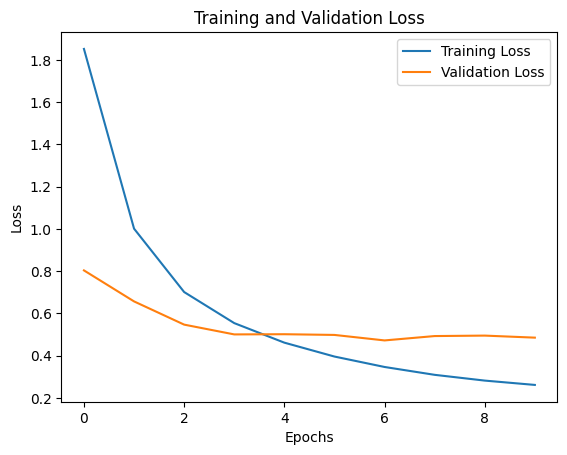

In [45]:
plot_training_curves(history_2gram)

Indeed, the graph seems to confirm the improvement, even though they still look quite similar. But we don't need to rely on our eyes, do we? Let's evaluate them and see which one wins!

In [46]:
loss_1gram, _  = model_1gram.evaluate(test_dataset_prep_1gram)
print(f"1-gram Model - MSE: {loss_1gram:.4f}")

loss_2gram, _ = model_2gram.evaluate(test_dataset_prep_2gram)
print(f"2-gram Model - MSE: {loss_2gram:.4f}")

235/235 [==============================] - 5s 20ms/step - loss: 0.5173 - mse: 0.5173
1-gram Model - MSE: 0.5173
235/235 [==============================] - 5s 23ms/step - loss: 0.4715 - mse: 0.4715
2-gram Model - MSE: 0.4715


The 2-gram model is almost 10% better: good news!

But we can still do better without acting on the architecture: by inspecting the vocabularies created by the `TextVectorization` layer we see quite a few words which have zero influence on sentiment (i.e. words like "the", "i", etc.). How do we make sure that these words matter very little? Simple: use TF-IDF!

### Complicating matters further: adding TF-IDF to our bigram model.

In [47]:
# we have the very convenient TextVectorizatoin layer for preprocessing!
text_vectorization_tfidf = layers.TextVectorization(
    ngrams=2,
    max_tokens=vocabulary_size,
    output_mode='tf_idf', # once again, it's that simple
    standardize='lower_and_strip_punctuation',
    split='whitespace',
)

In [48]:
text_vectorization_tfidf.adapt(train_dataset.map(lambda review, label: review))

In [49]:
text_vectorization_tfidf.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'i',
 'to',
 'was',
 'of',
 'is',
 'it',
 'for',
 'in',
 'my',
 'we',
 'with',
 'that',
 'but',
 'this',
 'they',
 'on',
 'you',
 'had',
 'have',
 'not',
 'were',
 'food',
 'so',
 'are',
 'good',
 'at',
 'place',
 'great',
 'be',
 'as',
 'very',
 'there',
 'all',
 'our',
 'if',
 'here',
 'out',
 'me',
 'of the',
 'it was',
 'service',
 'and the',
 'just',
 'like',
 'its',
 'time',
 'one',
 'get',
 'in the',
 'from',
 'their',
 'back',
 'would',
 'when',
 'or',
 'an',
 'go',
 'up',
 'really',
 'about',
 'which',
 'this place',
 'will',
 'been',
 'on the',
 'also',
 'some',
 'what',
 'i was',
 'and i',
 'no',
 'the food',
 'only',
 'more',
 'she',
 'can',
 'your',
 'us',
 'nice',
 'best',
 'got',
 'for a',
 'by',
 'he',
 'to the',
 'for the',
 'well',
 'because',
 'them',
 'dont',
 'even',
 'too',
 'staff',
 'other',
 'ordered',
 'love',
 'ive',
 'im',
 'i had',
 'friendly',
 'has',
 'delicious',
 'always',
 'after',
 'order',
 'do',
 'restaurant',
 'is a

In [50]:
train_dataset_prep_tfidf, val_dataset_prep_tfidf, test_dataset_prep_tfidf = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_tfidf)

In [51]:
model_tfidf = create_bow_model(vocabulary_size)

In [52]:
model_tfidf.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_8 (Dense)             (None, 256)               7680256   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

In [53]:
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_2gram_tfidf", save_best_only=True)
]

history_tfidf = model_tfidf.fit(
    # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
    train_dataset_prep_tfidf,
    validation_data=val_dataset_prep_tfidf,
    epochs=n_epochs,
    callbacks=callbacks,
    )

Epoch 1/10


2023-07-01 18:43:50.831383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 39902 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 27.8045 - mse: 27.8045

2023-07-01 18:43:58.323568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 2.9170 - mse: 2.9170INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 41s 21ms/step - loss: 2.9170 - mse: 2.9170 - val_loss: 0.6829 - val_mse: 0.6829
Epoch 2/10


2023-07-01 18:44:31.486138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41205 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 1.3909 - mse: 1.3909

2023-07-01 18:44:38.704993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 1.1541 - mse: 1.1541INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 41s 21ms/step - loss: 1.1541 - mse: 1.1541 - val_loss: 0.5961 - val_mse: 0.5961
Epoch 3/10


2023-07-01 18:45:12.017741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40917 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.9439 - mse: 0.9439

2023-07-01 18:45:19.118400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.8792 - mse: 0.8792INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.8795 - mse: 0.8795 - val_loss: 0.5360 - val_mse: 0.5360
Epoch 4/10


2023-07-01 18:45:52.060605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41657 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.8440 - mse: 0.8440

2023-07-01 18:45:58.984760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.7259 - mse: 0.7259INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 41s 22ms/step - loss: 0.7259 - mse: 0.7259 - val_loss: 0.5199 - val_mse: 0.5199
Epoch 5/10


2023-07-01 18:46:32.881556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40060 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 0.6583 - mse: 0.6583  

2023-07-01 18:46:40.580536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.6163 - mse: 0.6163INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 41s 22ms/step - loss: 0.6163 - mse: 0.6163 - val_loss: 0.5038 - val_mse: 0.5038
Epoch 6/10


2023-07-01 18:47:14.136607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 40763 of 70000


  13/1094 [..............................] - ETA: 15s - loss: 0.5672 - mse: 0.5672

2023-07-01 18:47:21.533032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.5589 - mse: 0.5589INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 20ms/step - loss: 0.5589 - mse: 0.5589 - val_loss: 0.4949 - val_mse: 0.4949
Epoch 7/10


2023-07-01 18:47:53.903884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41126 of 70000


  11/1094 [..............................] - ETA: 18s - loss: 0.6350 - mse: 0.6350

2023-07-01 18:48:01.311732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.5147 - mse: 0.5147INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.5146 - mse: 0.5146 - val_loss: 0.4867 - val_mse: 0.4867
Epoch 8/10


2023-07-01 18:48:34.208874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41343 of 70000


   9/1094 [..............................] - ETA: 16s - loss: 0.4624 - mse: 0.4624  

2023-07-01 18:48:41.356911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1093/1094 [============================>.] - ETA: 0s - loss: 0.4855 - mse: 0.4855INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 41s 22ms/step - loss: 0.4854 - mse: 0.4854 - val_loss: 0.4841 - val_mse: 0.4841
Epoch 9/10


2023-07-01 18:49:15.360532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41104 of 70000


  12/1094 [..............................] - ETA: 17s - loss: 0.4549 - mse: 0.4549

2023-07-01 18:49:22.697439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - ETA: 0s - loss: 0.4591 - mse: 0.4591INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


INFO:tensorflow:Assets written to: model_bow_2gram_tfidf/assets


1094/1094 [==============================] - 40s 21ms/step - loss: 0.4591 - mse: 0.4591 - val_loss: 0.4796 - val_mse: 0.4796
Epoch 10/10


2023-07-01 18:49:55.722976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 41297 of 70000


  13/1094 [..............................] - ETA: 16s - loss: 0.3981 - mse: 0.3981

2023-07-01 18:50:03.025241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


1094/1094 [==============================] - 40s 21ms/step - loss: 0.4389 - mse: 0.4389 - val_loss: 0.4896 - val_mse: 0.4896


Let's quickly inspect the situation visually, as above.

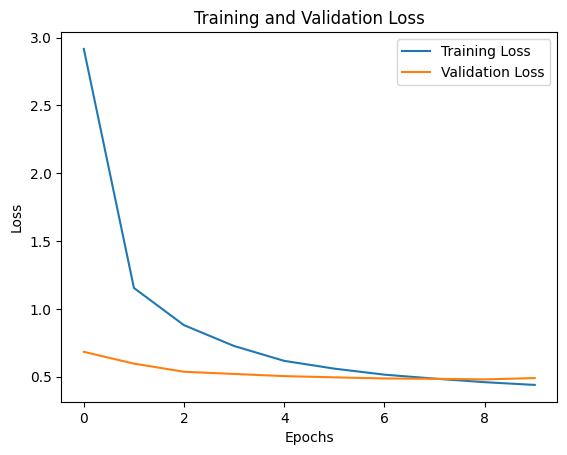

In [54]:
plot_training_curves(history_tfidf)

Doesn't look like there's much of an improvement in mere loss, but it seems that the overfitting is much better (the two curves almost overlap in the latter epochs).

Let's run a final evaluation to see what's what.

In [55]:
loss_1gram, _ = model_1gram.evaluate(test_dataset_prep_1gram)
print(f"1-gram Model - MSE: {loss_1gram:.4f}")

loss_2gram, _ = model_2gram.evaluate(test_dataset_prep_2gram)
print(f"2-gram Model - MSE: {loss_2gram:.4f}")

loss_tfidf, _ = model_tfidf.evaluate(test_dataset_prep_tfidf)
print(f"2-gram TF-IDF Model - MSE: {loss_tfidf:.4f}")

235/235 [==============================] - 5s 21ms/step - loss: 0.5173 - mse: 0.5173
1-gram Model - MSE: 0.5173
235/235 [==============================] - 5s 22ms/step - loss: 0.4715 - mse: 0.4715
2-gram Model - MSE: 0.4715
235/235 [==============================] - 5s 23ms/step - loss: 0.4742 - mse: 0.4742
2-gram TF-IDF Model - MSE: 0.4742


That's interesting: it doesn't seem like adding TF-IDF changed much at all (actually, it seems to have worsened performance).

Nevertheless, because there's quite a bit less overfitting.

## (Excursus) Could using the additional data provided by Yelp help make our model better?

In [56]:
rich_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   review_id     100000 non-null  object 
 1   user_id       100000 non-null  object 
 2   business_id   100000 non-null  object 
 3   stars         100000 non-null  float64
 4   text          100000 non-null  object 
 5   date          100000 non-null  object 
 6   name          100000 non-null  object 
 7   address       100000 non-null  object 
 8   city          100000 non-null  object 
 9   state         100000 non-null  object 
 10  postal_code   100000 non-null  object 
 11  latitude      100000 non-null  float64
 12  longitude     100000 non-null  float64
 13  review_count  100000 non-null  int64  
 14  is_open       100000 non-null  int64  
 15  attributes    98369 non-null   object 
 16  categories    99996 non-null   object 
 17  hours         94176 non-null   object 
dtypes: fl

We have plenty of information, but a lot of it is useless/confounding.
 - the 'useful', 'funny' and 'cool' columns contain information about the review itself, i.e. they're obtained posterior to the stars, so we should remove them (and we already did so in the beginning)
 - the 'date' column should be eliminated to remove spurious correlations (there might be a relationship between date and stars, but it's definitely not one we want to learn)
 - the 'name', 'address', 'city', 'state' and 'postal_code' columns should be eliminated because their information is contained in the 'latitude' and 'longitude' columns, so they're redundant
 - the 'is_open' column could be useful as a filtering step (i.e. we might only want to perform sentiment analysis on open businesses), but for simplification I'll drop it
 - the 'categories' column could also used as a filtering step (as it is on Kaggle, e.g. https://www.kaggle.com/code/niyamatalmass/finding-the-perfect-restaurants-on-yelp), but for simplification I'll drop it
 - the 'hours' column is as above, so I'll drop it as well

 At the end of the day we only provisionally keep the 'text', 'latitude', 'longitude', 'review_count' and 'attributes' columns for our features (and, clearly, the 'stars' column as labels)...

 Before our final decision, though, it's useful to get a bit more precise. Let's check out the correlation matrix of the columns we left in.

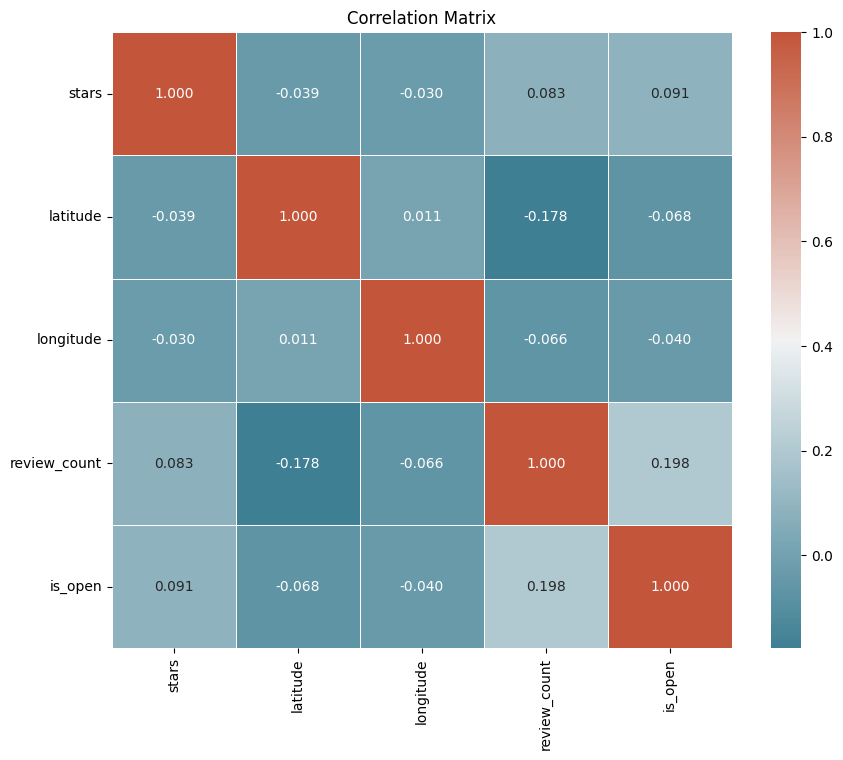

In [57]:
# compute the correlation matrix of the various numerical attributes
numeric_columns = rich_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_columns.corr()

# set color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

plt.figure(figsize=(10, 8))

# plot the correlation matrix
sns.heatmap(corr_matrix, cmap=cmap, annot=True, fmt=".3f", linewidths=0.5, cbar=True)

plt.title("Correlation Matrix")

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

It seems like the 'review_count', 'latitude' and 'longitude' columns are not that significant after all... Let's check it with a scatter plot.

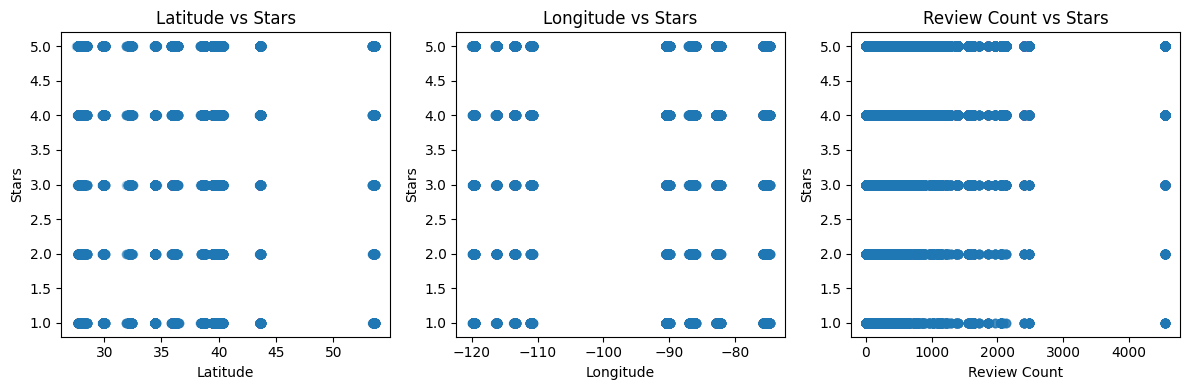

In [58]:
plt.figure(figsize=(12, 4))

# create a scatter plot for latitude vs stars
plt.subplot(131)
plt.scatter(rich_df['latitude'], rich_df['stars'], alpha=0.3)
plt.xlabel('Latitude')
plt.ylabel('Stars')
plt.title('Latitude vs Stars')

# create a scatter plot for longitude vs stars
plt.subplot(132)
plt.scatter(rich_df['longitude'], rich_df['stars'], alpha=0.3)
plt.xlabel('Longitude')
plt.ylabel('Stars')
plt.title('Longitude vs Stars')

# create a scatter plot for review_count vs stars
plt.subplot(133)
plt.scatter(rich_df['review_count'], rich_df['stars'], alpha=0.3)
plt.xlabel('Review Count')
plt.ylabel('Stars')
plt.title('Review Count vs Stars')

plt.tight_layout()

plt.show()

Oh wow, entirely horizontal... It seems that only the 'attributes' column is left, then.

In [59]:
X = rich_df[['text', 'attributes']]
y = rich_df['stars']

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        100000 non-null  object
 1   attributes  98369 non-null   object
dtypes: object(2)
memory usage: 1.5+ MB


The 'attributes' column looks intuitively interesting to me, and I already have an interesting idea as to how to use it (i.e. I'd like to learn some embeddings based on its contents and substitute the column with the latent values of this embedding).

But, to avoid useless work, it's a good idea to try to estimate its importance, or at least its viability in our context. The problem, in this case, is that this columns is not numerical (it actually containes nested JSON objects)...

In [61]:
X.iloc[0].attributes

{'NoiseLevel': "u'average'",
 'HasTV': 'False',
 'RestaurantsAttire': "'casual'",
 'BikeParking': 'False',
 'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
 'WiFi': "'free'",
 'DogsAllowed': 'False',
 'Alcohol': "'none'",
 'BusinessAcceptsCreditCards': 'True',
 'RestaurantsGoodForGroups': 'True',
 'RestaurantsPriceRange2': '2',
 'RestaurantsReservations': 'False',
 'WheelchairAccessible': 'True',
 'BusinessAcceptsBitcoin': 'False',
 'RestaurantsTableService': 'True',
 'GoodForKids': 'True',
 'Caters': 'False',
 'HappyHour': 'False',
 'RestaurantsDelivery': 'True',
 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}",
 'OutdoorSeating': 'True',
 'RestaurantsTakeOut': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"}

In [62]:
# let's try to flatten the column and see what we're working with...
def flatten_json_columns(df, columns):
    for col in columns:
        df_normalized = pd.json_normalize(df[col])
        df = df.drop(columns=[col])
        df = pd.concat([df, df_normalized], axis=1)
    return df

X = flatten_json_columns(X, ['attributes'])
# need to flatten further because of the extra nesting
X = flatten_json_columns(
    X, ['Ambience', 'GoodForMeal', 'BusinessParking'])

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   NoiseLevel                  73115 non-null   object
 2   HasTV                       72629 non-null   object
 3   RestaurantsAttire           70807 non-null   object
 4   BikeParking                 83583 non-null   object
 5   WiFi                        80187 non-null   object
 6   DogsAllowed                 42427 non-null   object
 7   Alcohol                     73054 non-null   object
 8   BusinessAcceptsCreditCards  94663 non-null   object
 9   RestaurantsGoodForGroups    72738 non-null   object
 10  RestaurantsPriceRange2      90112 non-null   object
 11  RestaurantsReservations     72372 non-null   object
 12  WheelchairAccessible        36623 non-null   object
 13  BusinessAcceptsBitcoin      21

That added a whole lot of columns, and most of them with plenty of nulls...

In [64]:
null_counts = X.isnull().sum()
sorted_columns = null_counts.sort_values() # sort columns based on number of null values in each

X[sorted_columns.index].info() # by the 18th column we're already at 60% of values being null!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   text                        100000 non-null  object
 1   BusinessAcceptsCreditCards  94663 non-null   object
 2   RestaurantsPriceRange2      90112 non-null   object
 3   BikeParking                 83583 non-null   object
 4   WiFi                        80187 non-null   object
 5   GoodForKids                 77828 non-null   object
 6   RestaurantsTakeOut          77366 non-null   object
 7   RestaurantsDelivery         75632 non-null   object
 8   OutdoorSeating              74694 non-null   object
 9   NoiseLevel                  73115 non-null   object
 10  Alcohol                     73054 non-null   object
 11  RestaurantsGoodForGroups    72738 non-null   object
 12  HasTV                       72629 non-null   object
 13  RestaurantsReservations     72

Indeed: take a look at those few final columns!

At this point we have two choices: we either leave the 'attributes' in, and engage in some **serious** data cleaning and feature engineering, or we dont. 

I'll opt for the second choice because 1) that would require quite a bit of time and, although interesting, would mostly be out of scope for the current project, and 2) intuitively speaking, a lot of this information should be in the review text itself, so the model probably already takes it into account.

In conclusion, it seems our initial approach of only utilising the text was a reasonable one, which is certainly quite comforting if nothing else.

## Time to get serious: let's use RNNs!

### Data preparation (repeated here for convenience)

In [65]:
def read_to_dataframe(file_path, max_nl=None):
    """
    Read a JSON file and convert its contents into a pandas DataFrame.

    Args:
        file_path (str): The path to the JSON file.
        max_nl (int, optional): The maximum number of lines to read. Defaults to None (read the whole file).

    Returns:
        pandas.DataFrame: The DataFrame containing the parsed JSON data.
    """
    with open(file_path, 'r') as f:
      data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

    return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    """
    Create train, validation, and test datasets from the given DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        feature_columns (list): List of column names representing the feature columns.
        label_column (str): The name of the column representing the label.
        train_size (float or int): The proportion or absolute number of samples for the training set.
        test_size (float or int): The proportion or absolute number of samples for the test set.
        random_state (int or None): Random state for reproducible results.
        
    Returns:
        tuple: A tuple containing X_train, X_val, X_test, y_train, y_val, y_test datasets.
    """
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    """
    Prepare the train, validation, and test datasets for model training and evaluation.
    
    Args:
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        test_dataset (tf.data.Dataset): The test dataset.
        m (int): The buffer size for shuffling the training dataset.
        preprocess_fn (callable): The preprocessing function to apply to the datasets.
        batch_size (int): The batch size for training, validation, and testing.
        
    Returns:
        tuple: A tuple containing the prepared train, validation, and test datasets.
    """
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepared = train_dataset.map(lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepared = train_dataset_prepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepared, val_dataset_prepared, test_dataset_prepared

In [66]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [67]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


The preparation of the `TextVectorization` and of the dataset should be repeated though!

In [68]:
if not first_run:
    # compute the maximum review length (useful for later padding)
    max_length = max(review_df['text'].apply(lambda x: len(x.split())))

    text_vectorization_rnn = layers.TextVectorization(
        max_tokens=vocabulary_size,
        output_mode='int', # i.e. each sentence will be a vector of ints (where each int is associated to a word)
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        output_sequence_length=max_length,
    )

In [69]:
if not first_run:
    text_vectorization_rnn.adapt(train_dataset.map(lambda review, label: review))

In [70]:
if not first_run:
    text_vectorization_rnn.get_vocabulary()

In [71]:
if not first_run:
    train_dataset_prep_rnn, val_dataset_prep_rnn, test_dataset_prep_rnn = prepare_for_model(
    train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_rnn)

### Let's define our first RNN model!

Our model will be a bidirectional LSTM-based model.

Bidirectionality means that the model traverses the sequence (i.e. our vector as obtained after passing it through the `TextVectorization` layer) in both directions (first from left to right then vice versa).

LSTM because we saw how bigrams did provide an improvement to our models, which indicates (unsurprisignly) that order matters and that local information is important, and LSTM are able to keep track of order information for quite a bit longer than standard RNNs (that's precisely why they're called **Long** Short Term Memory, after all).

In [72]:
def create_LSTM_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    one_hot = tf.one_hot(inputs, depth=num_words) # for simplicity
    lstm = layers.Bidirectional(layers.LSTM(32))(one_hot)
    outputs = layers.Dense(1)(lstm)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [73]:
if not first_run:
    lstm_model = create_LSTM_model(max_length, vocabulary_size)

In [74]:
if not first_run:
    lstm_model.summary()

In [75]:
if not first_run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm",
                                        save_best_only=True)
    ]

    # this takes A LOT longer than our previous models...
    history_lstm = lstm_model.fit(
        train_dataset_prep_rnn,
        validation_data=val_dataset_prep_rnn, 
        epochs=n_epochs//2,
        callbacks=callbacks)

That is some incredibly slow training... Is there any hope of training the model with the little compute offered us by the Colab environment? Why yes!

There are two additions we can make to our model to speed it up: use a `Conv1D` layer instead of RNNs and use an `Embedding` layer instead of `tf.one_hot()`.

The idea of using a `Conv1D` is absolutely brilliant and is entirely due to [Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition): it still takes care of local information (because it convolves the 1D kernel over the whole vector), and it still considers ordering (because convolution is not an order agnostic operation). Obviously we lose any form of memory, but maybe that's not too bad.

We'll have more to say on Embeddings later on.

### Let's try a Conv1D based model.

In [76]:
def create_conv1d_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    one_hot = tf.one_hot(inputs, num_words)
    conv1d = layers.Conv1D(32, 3, activation='relu')(one_hot)
    pool = layers.GlobalMaxPooling1D()(conv1d)

    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse'])
    
    return model

In [77]:
if not first_run:
    conv1d_model = create_conv1d_model(max_length, vocabulary_size)

In [78]:
if not first_run:
    conv1d_model.summary()

In [79]:
if not first_run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("one_hot_conv1d",
                                        save_best_only=True)
    ]

    # that's quite a bit better!
    history_conv1d = conv1d_model.fit(
        # no additional preparation needed!
        train_dataset_prep_rnn,
        validation_data=val_dataset_prep_rnn, 
        epochs=n_epochs//2,
        callbacks=callbacks)

Not bad: I see a 7x speed-up!

Now for the last addition: using an `Embedding` layer. In the code above, we used text vectorization to encode our sentences as integer vectors, but we haven't used this at all, because our space was still 30k dimensional (the `vocabulary_size`), and our model operated in that high-dimensional latent space.

Using embeddings, one the other hand, we can operate on a much lower dimensional space, thus speed up the model. In our case, the `Embedding` layer will be trainable as well, so we'll train the embeddings as we go, but we could probably speed up the process further if we used pre-trained embeddings (e.g. GloVe, or word2vec).

Naturally on top of the dimensionality concern we also get an advantage of operating in a semantically meaningful latent space, but that's an interesting topic that's out of scope for the current project.

### And use embeddings.

In [80]:
def create_conv1d_embed_model(max_length, num_words):
    inputs = layers.Input(shape=(max_length,), dtype="int64")

    embed = layers.Embedding(input_dim=num_words, output_dim=256)(inputs)
    conv1d = layers.Conv1D(32, 3, activation='relu')(embed)
    pool = layers.GlobalMaxPooling1D()(conv1d)

    outputs = layers.Dense(1)(pool)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse'])
    
    return model

In [81]:
if not first_run:
    conv1d_embed_model = create_conv1d_embed_model(max_length, vocabulary_size)

In [82]:
if not first_run:
    conv1d_embed_model.summary()

In [83]:
if not first_run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("conv1d_embed",
                                        save_best_only=True)
    ]

    # much better!
    history_conv1d_embed = conv1d_embed_model.fit(
        # once again, no further preparation needed (as a matter of fact, the data has been prepared for embedding all along)
        train_dataset_prep_rnn,
        validation_data=val_dataset_prep_rnn, 
        epochs=n_epochs//2,
        callbacks=callbacks)

Now that's a whole lot better! Let's check the training curves.

In [84]:
def plot_training_curves(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

if not first_run:
    plot_training_curves(history_conv1d_embed)

That's some serious overfitting!

And let's evaluate it.

In [85]:
if not first_run:
    loss, mse = conv1d_embed_model.evaluate(test_dataset_prep_rnn)
    print(f"1-gram Model - MSE: {mse:.4f}")

That's the worst model so far... 

Was it all for naught? Well, for one, this model was only trained on half the epochs. For two, there are quite a few more hyperparametres to manage here than in the FFN case, but I mostly set them to "default" values. Finally, the model is much shallower than the FFN one.

At the same time, this result seems to match what [Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition) found empirically, so it isn't that surprising after all.

That said, let's try the hot new model on the block as a last experiment. Let's play around with Transformers.

## Going even further: Transformers! 

### Data preparation (repeated here for convenience)

In [86]:
def read_to_dataframe(file_path, max_nl=None):
    """
    Read a JSON file and convert its contents into a pandas DataFrame.

    Args:
        file_path (str): The path to the JSON file.
        max_nl (int, optional): The maximum number of lines to read. Defaults to None (read the whole file).

    Returns:
        pandas.DataFrame: The DataFrame containing the parsed JSON data.
    """
    with open(file_path, 'r') as f:
      data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

    return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    """
    Create train, validation, and test datasets from the given DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        feature_columns (list): List of column names representing the feature columns.
        label_column (str): The name of the column representing the label.
        train_size (float or int): The proportion or absolute number of samples for the training set.
        test_size (float or int): The proportion or absolute number of samples for the test set.
        random_state (int or None): Random state for reproducible results.
        
    Returns:
        tuple: A tuple containing X_train, X_val, X_test, y_train, y_val, y_test datasets.
    """
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    """
    Prepare the train, validation, and test datasets for model training and evaluation.
    
    Args:
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        test_dataset (tf.data.Dataset): The test dataset.
        m (int): The buffer size for shuffling the training dataset.
        preprocess_fn (callable): The preprocessing function to apply to the datasets.
        batch_size (int): The batch size for training, validation, and testing.
        
    Returns:
        tuple: A tuple containing the prepared train, validation, and test datasets.
    """
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepared = train_dataset.map(lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepared = train_dataset_prepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepared, val_dataset_prepared, test_dataset_prepared

In [87]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [88]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


The preparation of the `TextVectorization` and of the dataset should be repeated though!

In [89]:
if not first_run:
    # compute the maximum review length (useful for later padding)
    max_length = max(rich_df['text'].apply(lambda x: len(x.split())))

    text_vectorization_transf = layers.TextVectorization(
        max_tokens=vocabulary_size,
        output_mode='int', # i.e. each sentence will be a vector of ints (where each int is associated to a word)
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        output_sequence_length=max_length,
    )

In [90]:
if not first_run:
    text_vectorization_transf.adapt(train_dataset.map(lambda review, label: review))

In [91]:
if not first_run:
    text_vectorization_transf.get_vocabulary()

In [92]:
if not first_run:
    train_dataset_prep_transf, val_dataset_prep_transf, test_dataset_prep_transf = prepare_for_model(
        train_dataset, val_dataset, test_dataset, len(X_train), text_vectorization_transf)

### Let's define a transformer encoder.

The code below is taken directly from Chollet's book, and commented throughout for clarity.

In [93]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim # size of input tokens
        self.dense_dim = dense_dim # size of inner dense layer
        self.n_heads = n_heads

        self.attention = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=embed_dim)

        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),]
        )

        self.layernorm_1 = layers.LayerNormalization() # works better than BatchNormalization, for textual data
        self.layernorm_2 = layers.LayerNormalization()

    # The call function does the actual computation, i.e. it's called when we do TransformerEncoder(...).
    def call(self, inputs, mask=None): 
        if mask is not None:
            # the Embedding layer will create a 2D mask, the attention layer needs it to be 3D or 4D 
            mask = mask[:, tf.newaxis, :]

        # the code below simply passes the input through all the components of the encoder, as specified by the diagram
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(proj_input + proj_output)

    # The get_config function serves serialization purposes, i.e. allows us to save and load the model.
    def get_config(self):
        config = super().get_config() 

        config.update({
            "embed_dim": self.embed_dim,
            "n_heads": self.n_heads,
            "dense_dim": self.dense_dim,
        })

        return config

Let's create a model only using the `TransformerEncoder` used above.

NOTE: We don't need a decoder because our model isn't seq2seq.

In [94]:
def create_transformer_model(vocabulary_size, embed_dim, n_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = layers.Embedding(vocabulary_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, n_heads)(x)
    x = layers.GlobalMaxPooling1D()(x) # the encoder will return sequences, but we need a single vector, so we flatten the seq with a pooling layer
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse"])

    return model

In [95]:
if not first_run:
    transformer_model = create_transformer_model(vocabulary_size, 256, 2, 32)

In [96]:
if not first_run:
    transformer_model.summary() # even with a single transformer encoder we get >8M parameters!

In [97]:
if not first_run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("transformer_encoder",
                                        save_best_only=True)
    ]

    # slow, but still faster than biderectional RNNs!
    transformer_history = transformer_model.fit(
        train_dataset_prep_transf,
        validation_data=val_dataset_prep_transf,
        epochs=n_epochs//2,
        callbacks=callbacks)

The training proceeds rather slowly (but still much faster than our bidirectional LSTM model).

There's a bigger problem though: we've completely ignored positional information. We can easily remedy this, though. (As for the `TransformerEncoder` the code below is taken from [Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition))

In [98]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # this will keep track of position
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)

        self.sequence_length = sequence_length 
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        # add both embeddings => i.e. add positional information to our tokens
        return embedded_tokens + embedded_positions

    # This function allows use to compute a mask, which in turn allows us to save on computation (we don't do anythin when this mask is zero, so we don't need to process the padding).
    # It will be called automatically and managed by keras.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config() 

        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })

        return config

In [99]:
def create_pos_transformer_model(vocabulary_size, max_length, embed_dim, n_heads, dense_dim):
    inputs = keras.Input(shape=(None,), dtype="int64")

    x = PositionalEmbedding(max_length, vocabulary_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, n_heads)(x)
    x = layers.GlobalMaxPooling1D()(x) # the encoder will return sequences, but we need a single vector, so we flatten the seq with a pooling layer
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam",
                loss="mean_squared_error",
                metrics=["mse"])

    return model

In [100]:
if not first_run:
    pos_transformer_model = create_pos_transformer_model(vocabulary_size, max_length, 256, 2, 32)

In [101]:
if not first_run:
    pos_transformer_model.summary()

In [102]:
if not first_run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("pos_transformer_encoder",
                                        save_best_only=True)
    ]

    # adding the positional embedding only makes the model a little slower, good news!
    pos_transformer_history = pos_transformer_model.fit(
        train_dataset_prep_transf,
        validation_data=val_dataset_prep_transf,
        epochs=n_epochs//2,
        callbacks=callbacks)

That made the model a bit faster even. Interesting! It is still quite slow, though.

## Back to Bag-of-Words: Fine-tuning edition.

Ok, so we've looked at a good deal of different architectures so far, but we only trained one alternative, the `Conv1D` + `Embedding` model, simply because it was the quickest to train. Naturally, if we had the patience/compute we could also train the rest. 

But, in this case, our bigram Bag-of-Words model seemed to perform quite well, so why not spend some time fine-tuning it instead? This is exactly what we'll be doing in this (final) section.

### Data preparation (repeated here for convenience)

In [103]:
def read_to_dataframe(file_path, max_nl=None):
    """
    Read a JSON file and convert its contents into a pandas DataFrame.

    Args:
        file_path (str): The path to the JSON file.
        max_nl (int, optional): The maximum number of lines to read. Defaults to None (read the whole file).

    Returns:
        pandas.DataFrame: The DataFrame containing the parsed JSON data.
    """
    with open(file_path, 'r') as f:
      data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

    return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    """
    Create train, validation, and test datasets from the given DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        feature_columns (list): List of column names representing the feature columns.
        label_column (str): The name of the column representing the label.
        train_size (float or int): The proportion or absolute number of samples for the training set.
        test_size (float or int): The proportion or absolute number of samples for the test set.
        random_state (int or None): Random state for reproducible results.
        
    Returns:
        tuple: A tuple containing X_train, X_val, X_test, y_train, y_val, y_test datasets.
    """
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    """
    Prepare the train, validation, and test datasets for model training and evaluation.
    
    Args:
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        test_dataset (tf.data.Dataset): The test dataset.
        m (int): The buffer size for shuffling the training dataset.
        preprocess_fn (callable): The preprocessing function to apply to the datasets.
        batch_size (int): The batch size for training, validation, and testing.
        
    Returns:
        tuple: A tuple containing the prepared train, validation, and test datasets.
    """
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepared = train_dataset.map(lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepared = train_dataset_prepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepared, val_dataset_prepared, test_dataset_prepared

In [104]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
vocabulary_size = 30_000
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [105]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=25_000)

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (17500,) (17500,)
Validation set shape: (3750,) (3750,)
Testing set shape: (3750,) (3750,)


### Let's quickly define the model for now (we'll worry about fine-tuning it in a bit).

In [106]:
# notice the extra input arguments!
def create_bow_model(input_dim, hidden_dims, activations, p=0.5, lr=0.01):
    # using the sequential API makes for cleaner code here
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(input_dim,)))
    for i in range(len(hidden_dims)):
        model.add(layers.Dense(hidden_dims[i], activation=activations[i]))
        model.add(layers.Dropout(p))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model

### We shall start by tuning the parameters of the `TextVectorization` layer.

Two parameters looks amenable to fine-tuning: the `max_tokens` and the `ngrams`.

To make experimentation easier and more comfortable, it's a good idea to enclose the vectorization procedure in a function.

In [107]:
def vectorize(ngrams, vocabulary_size):
    text_vectorization_ngram = layers.TextVectorization(
        ngrams=ngrams,
        max_tokens=vocabulary_size,

        output_mode='multi_hot',
        standardize='lower_and_strip_punctuation',
        split='whitespace',
    )

    text_vectorization_ngram.adapt(train_dataset.map(lambda review, label: review))

    return text_vectorization_ngram

Everything seems well set up, so let's try a few values. (You can add some of your own if you wish, but I believe the one I chose offer a good compromise between completeness and compute time).

NOTE: The cell below could take quite a bit to run...

In [108]:
if not first_run:
    vocab_sizes = [15_000, 20_000, 25_000, 30_000, 35_000]
    ngrams = [3, 4, 5, 6]

    hidden_dims = [64, 32] # simple and fast, to not waste too much time
    activations = ['relu' for _ in range(len(hidden_dims))]

    histories = {}
    for ngram in ngrams:
        for vs in vocab_sizes:
            text_vec = vectorize(ngram, vs)
            train_dataset_prep_ngram, val_dataset_prep_ngram, test_dataset_prep_ngram = prepare_for_model(
                train_dataset, val_dataset, test_dataset, len(X_train), text_vec) 

            model = create_bow_model(vs, hidden_dims, activations)
            history = model.fit(
                train_dataset_prep_ngram, 
                validation_data=val_dataset_prep_ngram, 
                epochs=n_epochs//3,
                verbose=0)

            print(f"[+] (ngrams = {ngram}, vocabulary_size = {vs}), best validation loss: {min(history.history['val_loss'])}")

Interesting, it seems we get the best validation loss with `ngrams = 6` and `vocabulary_size = 20_000`. Let's proceed with those!

### Let's now worry about the model, shall we?

#### Set up the fine-tuned `TextVectorization` layer.

In [109]:
best_vocabulary_size = 20_000
best_ngrams = 6

In [110]:
if not first_run:
    best_text_vectorization_ngram = layers.TextVectorization(
        ngrams=best_ngrams,
        max_tokens=best_vocabulary_size,
        output_mode='multi_hot',
        standardize='lower_and_strip_punctuation',
        split='whitespace',
    )

    best_text_vectorization_ngram.adapt(train_dataset.map(lambda review, label: review))

    train_dataset_prep_ngram, val_dataset_prep_ngram, test_dataset_prep_ngram = prepare_for_model(
        train_dataset, val_dataset, test_dataset, len(X_train), best_text_vectorization_ngram) 

In [111]:
if not first_run:
    best_text_vectorization_ngram.get_vocabulary()

#### Finally, let's play around with model hyperparameters!

Let's take it one hyperparameter at a time to avoid confusion: let's start with possibly the most important thing for overall performance, i.e. model architecture.

NOTE: I could go about this much more systematically using `sklearn` (e.g. `GridSearchCV`) or `keras_tuner`, but I chose the manual way for speed and simplicity.

In [112]:
if not first_run:
    hidden_dimss = [
        [128, 64],
        [256, 128, 64],
        [256, 128, 128], 
        [256, 256, 128], 
        [256, 256, 128, 64]
        # increasing the size further risks causing problems with Colab's RAM
        ]

    for hidden_dims in hidden_dimss:
        activations = ['relu' for _ in range(len(hidden_dims))] # let's keep it simple for now
        model = create_bow_model(best_vocabulary_size, hidden_dims, activations)

        history = model.fit(
            train_dataset_prep_ngram,
            validation_data=val_dataset_prep_ngram,
            epochs=n_epochs//2, 
            verbose=0)

        print(f"[+] Architecture: {hidden_dims}, best validation loss: {min(history.history['val_loss'])}")

That's a rather fascinating result: one would expect more complex networks to perform better, and yet they last one is worse! One possibility is clearly overfitting. Another is possibly the diminished amount of data available (I'm only using 25k datapoints, after all, and only 70% of those for training).

There might be an even more interesting reason than that, though: it's possibly about network topology! Interesting, yes, but also out of scope, so let's proceed, shall we?

In [113]:
if not first_run:
    best_hidden_dims = hidden_dimss[-2]
    best_hidden_dims

Great! Now let's see if activation different functions help.

In [114]:
if not first_run:
    # for simplicity, keep the activation function the same for all layers
    activationss = [
        ['relu' for _ in range(len(hidden_dims))],
        ['tanh' for _ in range(len(hidden_dims))],
        ['sigmoid' for _ in range(len(hidden_dims))],
        ['selu' for _ in range(len(hidden_dims))],
    ]

    for activations in activationss:
        model = create_bow_model(best_vocabulary_size, best_hidden_dims, activations)

        history = model.fit(
            train_dataset_prep_ngram,
            validation_data=val_dataset_prep_ngram,
            epochs=n_epochs//3, 
            verbose=0)

        print(f"[+] Activation: {activations[0]}, best validation loss: {min(history.history['val_loss'])}")

Looks like the good ol' sigmoid wins.

In [115]:
if not first_run:
    best_activations = activationss[-2]
    best_activations

Let's experiment with different values for the `Dropout` layer...

In [116]:
if not first_run:
    ps = [p/100 for p in range(20, 60 + 1, 10)] # [0.2, 0.3, ..., 0.6]

    for p in ps:
        model = create_bow_model(best_vocabulary_size, best_hidden_dims, best_activations, p=p)

        history = model.fit(
            train_dataset_prep_ngram,
            validation_data=val_dataset_prep_ngram,
            epochs=n_epochs//3, 
            verbose=0)

        print(f"[+] Dropout p: {p}, best validation loss: {min(history.history['val_loss'])}")

That's more or less the `p` I expected...

In [117]:
if not first_run:
    best_p = ps[-3]
    best_p

Finally, let's try different learning rates.

In [118]:
if not first_run:
    lrs = [0.1, 0.01, 0.001, 0.0001] # some common values for the lr

    for lr in lrs:
        model = create_bow_model(best_vocabulary_size, best_hidden_dims, best_activations, p=best_p, lr=lr)

        history = model.fit(
            train_dataset_prep_ngram,
            validation_data=val_dataset_prep_ngram,
            epochs=n_epochs//2, 
            verbose=0)

        print(f"[+] Learning rate: {lr}, best validation loss: {min(history.history['val_loss'])}")

Seems like the default learning rate was best. Still, it's always nice to get some stronger evidence for it.

In [119]:
if not first_run:
    best_lr = lrs[1]
    best_lr

## Train our fine-tuned model.

### Data preparation (repeated here for convenience)

In [120]:
def read_to_dataframe(file_path, max_nl=None):
    """
    Read a JSON file and convert its contents into a pandas DataFrame.

    Args:
        file_path (str): The path to the JSON file.
        max_nl (int, optional): The maximum number of lines to read. Defaults to None (read the whole file).

    Returns:
        pandas.DataFrame: The DataFrame containing the parsed JSON data.
    """
    with open(file_path, 'r') as f:
      data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

    return pd.DataFrame(data)

def create_datasets(df, feature_columns, label_column, train_size, test_size, random_state=None):
    """
    Create train, validation, and test datasets from the given DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        feature_columns (list): List of column names representing the feature columns.
        label_column (str): The name of the column representing the label.
        train_size (float or int): The proportion or absolute number of samples for the training set.
        test_size (float or int): The proportion or absolute number of samples for the test set.
        random_state (int or None): Random state for reproducible results.
        
    Returns:
        tuple: A tuple containing X_train, X_val, X_test, y_train, y_val, y_test datasets.
    """
    X = df[feature_columns]
    y = df[label_column]

    # we use stratification to mantain similar proportions across the various splits (the distribution is quite asymmetrical, after all)
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=random_state)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test_val, y_test_val, test_size=test_size, stratify=y_test_val, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

def prepare_for_model(train_dataset, val_dataset, test_dataset, m, preprocess_fn, batch_size=64):
    """
    Prepare the train, validation, and test datasets for model training and evaluation.
    
    Args:
        train_dataset (tf.data.Dataset): The training dataset.
        val_dataset (tf.data.Dataset): The validation dataset.
        test_dataset (tf.data.Dataset): The test dataset.
        m (int): The buffer size for shuffling the training dataset.
        preprocess_fn (callable): The preprocessing function to apply to the datasets.
        batch_size (int): The batch size for training, validation, and testing.
        
    Returns:
        tuple: A tuple containing the prepared train, validation, and test datasets.
    """
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepared = train_dataset.map(lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(lambda review, label: (preprocess_fn(review), label))

    # shuffle and batch the training dataset
    train_dataset_prepared = train_dataset_prepared.shuffle(m).batch(batch_size)

    # batch the validation and testing datasets
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepared, val_dataset_prepared, test_dataset_prepared

In [121]:
data_dir = "yelp-data/" # splitting data up like this might be useful for later (in case i want to use other files)
train_size = 0.7 # the percentage of data reserved for training
test_size = 0.5 # the percentage of data reserved for testing (from the data that remains)
n_epochs = 10 # adjust this if the model trains too slowly (or modify model parameters as desired...)

In [122]:
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

X_train, X_val, X_test, y_train, y_val, y_test = create_datasets(
    review_df, 'text', 'stars', train_size, test_size, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Create TensorFlow datasets for the training, validatoin and test data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Training set shape: (70000,) (70000,)
Validation set shape: (15000,) (15000,)
Testing set shape: (15000,) (15000,)


### Text vectorization

In [124]:
if not first_run:
    # WARNING: this will likely take a really long time (~2min)!
    best_ngrams = 6
    best_vocabulary_size = 20_000

    best_text_vectorization_ngram = layers.TextVectorization(
        ngrams=best_ngrams,
        max_tokens=best_vocabulary_size,
        output_mode='multi_hot',
        standardize='lower_and_strip_punctuation',
        split='whitespace',
    )

    best_text_vectorization_ngram.adapt(train_dataset.map(lambda review, label: review))

    train_dataset_prep_ngram, val_dataset_prep_ngram, test_dataset_prep_ngram = prepare_for_model(
        train_dataset, val_dataset, test_dataset, len(X_train), best_text_vectorization_ngram) 

### Model building and instatiation

In [125]:
# set p and lr to their best values already
def create_bow_model(input_dim, hidden_dims, activations, p=0.4, lr=0.01):
    # using the sequential API makes for cleaner code here
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(input_dim,)))
    for i in range(len(hidden_dims)):
        model.add(layers.Dense(hidden_dims[i], activation=activations[i]))
        model.add(layers.Dropout(p))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model
    
def plot_training_curves(history):
    """
    Plot the training and validation loss curves.

    Args:
        history: History object returned by the model training process.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

In [126]:
if not first_run:
    best_hidden_dims = [256, 256, 128]
    best_activations = ['sigmoid' for _ in range(len(best_hidden_dims))]

    model_bow_best = create_bow_model(best_vocabulary_size, best_hidden_dims, best_activations)

In [127]:
if not first_run:
    model_bow_best.summary()

### Let's train it!

In [128]:
if not first_run:
    callbacks = [
        keras.callbacks.ModelCheckpoint("model_bow_best", save_best_only=True),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), # train the model for as long as it improves
    ]

In [129]:
if not first_run:
    history_best_model = model_bow_best.fit(
        # one could .cache() this data to speed up training, but I didn't do it to take up less RAM
        train_dataset_prep_ngram,
        validation_data=val_dataset_prep_ngram,
        epochs=n_epochs * 5, # a really high number, it's unlikely to get this far because of EarlyStopping
        callbacks=callbacks,
        )

Let's see what happened!

In [130]:
if not first_run:
    plot_training_curves(history_best_model)

In [131]:
if not first_run:
    # if you want to check my saved model uncomment this line before evaluating
    # model_bow_best = keras.models.load_model("saved/models/model_bow_best")
    model_bow_best.evaluate(test_dataset_prep_ngram) 

Surprisingly, it performs a bit worse than our 2-gram model (the loss of which was 0.4507 on the test set). And there's clearly some prominent overfitting! Not the result we were hoping for...

Still, not all hope is lost and the underperfomance of our "best" model could well be a stochastic fluke. Even more so, though, the overfitting points us in a possible direction of improvement: we need to use more data!

## Using more data 

Usually, when one wants to improve the a machine learning model further there are two possibilities: more (and/or better) data and/or a different (possibly more complex) architecture. The latter option will be ignored by us, because there are only so many resources Colab allows us to use, so in this section we'll focus on the former option, i.e. using more data. 

The problem, naturally, is that we have a very large dataset which, if read as a whole, would take a great amount of time to transfer to RAM (and would probably crash the kernel in the meanwhile). So, what now?

### Let's repeat the useful code here, for convenience

In [136]:
def prepare_for_model_online(train_dataset, val_dataset, test_dataset, preprocess_fn, batch_size=64):
    # apply the preprocessing pipeline to the datasets
    train_dataset_prepepared = train_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    val_dataset_prepared = val_dataset.map(
        lambda review, label: (preprocess_fn(review), label))
    test_dataset_prepared = test_dataset.map(
        lambda review, label: (preprocess_fn(review), label))

    # batch the training dataset (notice that we're not shuffling when preparing for the online model!)
    train_dataset_prepepared = train_dataset_prepepared.batch(batch_size)
    val_dataset_prepared = val_dataset_prepared.batch(batch_size)
    test_dataset_prepared = test_dataset_prepared.batch(batch_size)

    return train_dataset_prepepared, val_dataset_prepared, test_dataset_prepared

# set p and lr to their best values right away
def create_bow_model(input_dim, hidden_dims, activations, p=0.4, lr=0.01):
    # using the sequential API makes for cleaner code here
    model = keras.Sequential()
    
    model.add(layers.Input(shape=(input_dim,)))
    for i in range(len(hidden_dims)):
        model.add(layers.Dense(hidden_dims[i], activation=activations[i]))
        model.add(layers.Dropout(p))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model
    
def plot_training_curves(history):
    """
    Plot the training and validation loss curves.

    Args:
        history: History object returned by the model training process.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

In [137]:
# adjust the kwarg 'max_nl' depending on how much time you're willing to wait and how much RAM is available (leave None if you want to read the whole file)
def read_to_dataframe(file, max_nl=None):
  with open(file, 'r') as f:
    data = [json.loads(line) for line in f] if max_nl is None else [json.loads(next(f)) for _ in range(max_nl)]

  return pd.DataFrame(data)

data_dir = "yelp-data/" 
review_file = "yelp_academic_dataset_review.json"
review_df = read_to_dataframe(data_dir + review_file, max_nl=100_000)

# use all the data for adapting the TextVectorization layer
X_train, y_train = review_df['text'], review_df['stars']
print("Training set shape:", X_train.shape, y_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

Training set shape: (100000,) (100000,)


In [138]:
if not first_run:
    best_vocabulary_size = 20_000
    best_ngrams = 6

    best_text_vectorization_online = layers.TextVectorization(
        ngrams=best_ngrams,
        max_tokens=best_vocabulary_size,
        output_mode='multi_hot',
        standardize='lower_and_strip_punctuation',
        split='whitespace',
    )

    best_text_vectorization_online.adapt(train_dataset.map(lambda review, label: review))

### Improving our model with online learning

Let's try to use online learning: we can do it all with `keras` and `TensorFlow`! All we need to do is to feed the data into our model using a generator.

We need to first define a (python) generator...

In [139]:
def data_generator(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            if line is None:
                break

            line = json.loads(line)
            yield line['text'], line['stars']

...and then, because keras is that awesome, simply create a dataset from it! This dataset will behave precisely as a "standard" Dataset, which means that we can apply the usual operations to it without having to implement much of anything manually.

In [140]:
train_file = data_dir + "train_" + review_file
val_file = data_dir + "val_" + review_file
test_file = data_dir + "test_" + review_file

In [142]:
if not first_run:
    train_dataset_online = tf.data.Dataset.from_generator(
        data_generator, args=[train_file],
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.float32)))
    val_dataset_online = tf.data.Dataset.from_generator(
        data_generator, args=[val_file], 
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.float32)))
    test_dataset_online = tf.data.Dataset.from_generator(
        data_generator, args=[test_file], 
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.float32)))


    train_dataset_prep_online, val_dataset_prep_online, test_dataset_prep_online = prepare_for_model_online(
        train_dataset_online, val_dataset_online, test_dataset_online, best_text_vectorization_online)     

Ok! Let's load our previous model and improve it some more.

In [143]:
if not first_run:
    # uncomment the line below if you want to try using your model (note that it might not reach the target validation loss as fast as mine, so you could have to wait quite a bit more)
    # model_bow_online = keras.models.load_model("model_bow_best")
    model_bow_online = keras.models.load_model("saved/models/model_bow_best")

In [144]:
if not first_run:
    model_bow_online.summary()

In [145]:
# the callback below is to stop training from taking an exceedingly long time (if you're willing to wait, simply remove it form the list of callbacks)
class TargetLossCallback(keras.callbacks.Callback):
    def __init__(self, target_loss):
        super(TargetLossCallback, self).__init__()
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] <= self.target_loss:
            self.model.stop_training = True
            print(f"\n[+] Reached target validation loss of {self.target_loss}. Stopping training.\n")

target_val_loss = 0.4
callbacks = [
    keras.callbacks.ModelCheckpoint("model_bow_best_online", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True), # train the model for as long as it improves
    TargetLossCallback(target_loss=0.4) # let's not be excessively ambitious...
]

In [146]:
if not first_run:
    history_online = model_bow_online.fit(
        train_dataset_prep_online,
        validation_data=val_dataset_prep_online,
        validation_steps=1000,
        epochs=50,
        steps_per_epoch=1000,
        callbacks=callbacks)

In [147]:
if not first_run:
    plot_training_curves(history_online)

In [148]:
if not first_run:
    model_bow_online.evaluate(test_dataset_prep_online, steps=1000)

That's a 10+% improvement! Not too shabby...

### The end?

Naturally, there are plenty of things left to do to improve the model: first off, it's probably a good idea to change architecture and use either Transformers or RNNs. As a further step, it would probably be useful to train the model on ALL the available data, possibly further fine-tune the various parameters more systematically. We could also attmpt to fine-tune pretrained models, in case performance doesn't improve enough; we could also try using pretrained embeddings. Et cetera.

The possibilities are (almost) endless, as it is with every ML project, but I shall end it here for now!